In [1]:
"""
The complete annotation is in autoencoder_practice.py
"""

# ------ import modules ------
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
from tqdm import tqdm
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.layers import Dense, Input
from keras.models import Model, Sequential
from keras.datasets import mnist

Using plaidml.keras.backend backend.


In [2]:
# ----- model constuction ------
# - autoencoder (complete model) -
encoding_dim = 32  # compressed size

# Below: input tensor object.
input_img = Input(shape=(784, ))

# Chain 1, encoding layer: from 784 to 32
encoded = Dense(encoding_dim, activation='relu')(input_img)

# Chain 2, encoding layer: from 32 to 784
# NOTE: 0,1 is the output format, simoid
decoded = Dense(784, activation='sigmoid')(encoded)

# - Final model -
autoencoder = Model(input_img, decoded)

# - Seperate encoder model -
encoder = Model(input_img, encoded)

# - Seperate decoder model -
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

INFO:plaidml:Opening device "metal_amd_radeon_pro_5500_xt.0"


In [3]:
# ------ train the model ------
# - compile/configure the models -
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# - load the MINST data -
(x_train, y_train), (x_test, y_test) = mnist.load_data()
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# data rescaling to 0-1: min (0)-max(255) normalization
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# data reshape: 60000, 28, 28 -> 60000, 28*28 = 60000, 784
x_train = x_train.reshape(len(x_train), np.prod(x_train.shape[1:]))
x_test = x_test.reshape(len(x_test), np.prod(x_test.shape[1:]))

# x_train_s = x_train[:50, :]
# x_test_s = x_test[:10, :]

In [4]:
# - fit the model -
# early stop
earlystop_callback = EarlyStopping(monitor='val_loss', patience=5)
callbacks = [earlystop_callback] # callback is a list

# fitting
"""
input, output = x_train,, x_train: because the input and outpout are the same for autoencoder 
batch_size: we don't set the number of batches. Instead, we set batch_size, which will determine the number of batches
    given the total sample number. 
"""
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256, callbacks=callbacks,
                shuffle=True, validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 38us/step - loss: 0.2776 - val_loss: 0.1884
Epoch 2/50
60000/60000 [==============================] - 1s 14us/step - loss: 0.1701 - val_loss: 0.1536
Epoch 3/50
60000/60000 [==============================] - 1s 14us/step - loss: 0.1449 - val_loss: 0.1347
Epoch 4/50
60000/60000 [==============================] - 1s 14us/step - loss: 0.1296 - val_loss: 0.1227
Epoch 5/50
60000/60000 [==============================] - 1s 14us/step - loss: 0.1196 - val_loss: 0.1142
Epoch 6/50
60000/60000 [==============================] - 1s 14us/step - loss: 0.1125 - val_loss: 0.1083
Epoch 7/50
60000/60000 [==============================] - 1s 14us/step - loss: 0.1073 - val_loss: 0.1037
Epoch 8/50
60000/60000 [==============================] - 1s 14us/step - loss: 0.1034 - val_loss: 0.1004
Epoch 9/50
60000/60000 [==============================] - 1s 14us/step - loss: 0.1004 - val_loss: 0.0980
Epoch

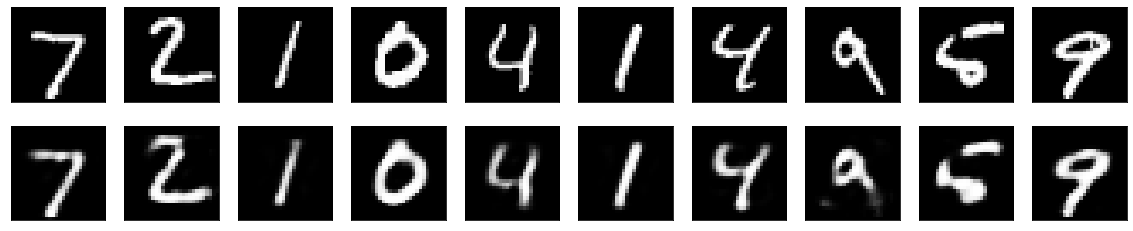

In [5]:
# ------ display resutls ------
# - predict -
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)  # get the encoded image
decoded_imgs = decoder.predict(encoded_imgs)  # decode the encoded image

# - visulization -
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [6]:
encoded_imgs[0, :]

array([ 6.7625155,  8.355247 ,  1.5891633,  8.520826 ,  7.537199 ,
        4.429767 ,  4.029958 ,  4.0883145, 10.830561 ,  7.538973 ,
        5.941377 , 10.922392 ,  4.812436 ,  5.5407405,  7.03783  ,
        0.759146 ,  6.5985756,  8.064661 ,  1.2654914,  4.702437 ,
        8.253177 ,  7.917054 , 14.23715  ,  4.896682 ,  6.1442876,
        4.074359 ,  2.4219701,  4.8741465,  4.6177435,  2.9189553,
       15.170843 , 13.03728  ], dtype=float32)